In [1]:
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import numpy as np

df_cpi = pd.read_csv("cpi.csv") #pandas assumes us date format month first #nulls at end [ONLY]
#df_cpi.dropna() #added 211206
df_ber = pd.read_csv("t10y.csv") #pandas assumes us date format month first #nulls in middle

df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4122 entries, 0 to 4121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4122 non-null   object 
 1   CPI     4087 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.5+ KB


In [2]:
df_ber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4393 entries, 0 to 4392
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    4393 non-null   object 
 1   T10YIE  4215 non-null   float64
dtypes: float64(1), object(1)
memory usage: 68.8+ KB


In [3]:
#Get monthly CPI as first day of each month
#from 8/1/2008
#to 10/1/2019
df_cpi['date'] = pd.to_datetime(df_cpi['date'])
df_cpi = df_cpi[df_cpi['date'].dt.day == 1]
df_cpi.index = np.arange(len(df_cpi))
df_cpi.head()


,date,CPI
0,2008-07-01,100.00000
1,2008-08-01,100.52510
2,2008-09-01,100.12380
3,2008-10-01,99.98538
4,2008-11-01,98.97539


<function matplotlib.pyplot.show(close=None, block=None)>

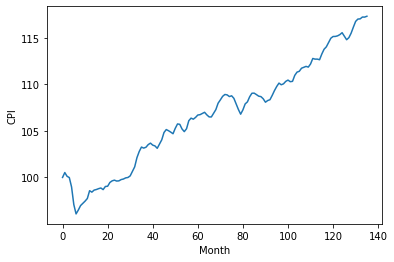

In [4]:
plt.xlabel("Month")
plt.ylabel("CPI")
plt.plot(np.arange(len(df_cpi)),df_cpi['CPI'])
plt.show

In [5]:
#Fit linear trend to readings BEFORE 1st Sept 2013
cpi_train = df_cpi[df_cpi['date'] < '2013-09-01']['CPI'].to_numpy().reshape(-1, 1)
#cpi_train.tail()
cpi_test = df_cpi[df_cpi['date'] >= '2013-09-01']['CPI'].to_numpy().reshape(-1, 1)
#cpi_test.head()

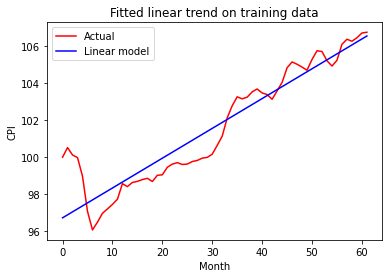

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(np.arange(len(cpi_train)).reshape(-1, 1),cpi_train)
plt.title("Fitted linear trend on training data")
plt.xlabel("Month")
plt.ylabel("CPI")
plt.plot(np.arange(len(cpi_train)),cpi_train,'r-',label='Actual')
plt.plot(np.arange(len(cpi_train)),model.predict(np.arange(len(cpi_train)).reshape(-1, 1)),'b-',label='Linear model')
plt.legend()
plt.show()

In [7]:
print(f"Intercept: {model.intercept_} Coeffs: {model.coef_}")
print(f"This is slightly different because I take the 1st of each month and therefore miss 1 reading")


Intercept: [96.72932633] Coeffs: [[0.16104348]]
This is slightly different because I take the 1st of each month and therefore miss 1 reading


max:1.6198972307420973 min: -3.634730187605456


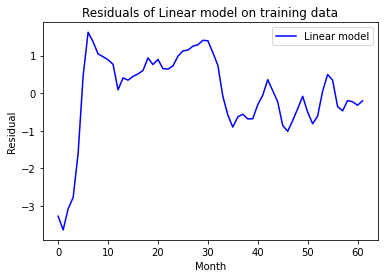

No clear trend or seasonality


In [8]:
#Generate the residuals
df_cpi.loc[:,("linear_trend")] = model.predict(np.arange(len(df_cpi)).reshape(-1,1))
df_cpi.loc[:,("trend_residuals")] = df_cpi.loc[:,("linear_trend")]-df_cpi.loc[:,("CPI")]
print(f"max:{df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'].max()} min: {df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'].min()}")
plt.title("Residuals of Linear model on training data")
plt.xlabel("Month")
plt.ylabel("Residual")
#plt.plot(np.arange(len(cpi_train)),cpi_train,'r-',label='Actual')
plt.plot(np.arange(len(cpi_train)),df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'],'b-',label='Linear model')
plt.legend()
plt.show()
print(f"No clear trend or seasonality")

In [9]:
print(f"na values before: {df_cpi.isna().sum().sum()}")
df_cpi.tail()


na values before: 2


,date,CPI,linear_trend,trend_residuals
132,2019-07-01,117.0592,117.987066,0.927866
133,2019-08-01,117.2548,118.148110,0.893310
134,2019-09-01,117.2488,118.309153,1.060353
135,2019-10-01,117.3407,118.470197,1.129497
136,2019-11-01,NaN,118.631240,NaN


In [10]:
df_cpi = df_cpi.dropna()
df_cpi.tail()

,date,CPI,linear_trend,trend_residuals
131,2019-06-01,117.0359,117.826023,0.790123
132,2019-07-01,117.0592,117.987066,0.927866
133,2019-08-01,117.2548,118.148110,0.893310
134,2019-09-01,117.2488,118.309153,1.060353
135,2019-10-01,117.3407,118.470197,1.129497


In [11]:
#Check for Stationarity

stationarity_BIC = sm.tsa.stattools.adfuller(df_cpi['trend_residuals'],autolag='BIC')
print(f"BIC P-value: {stationarity_BIC[1]} Lag Used: {stationarity_BIC[2]}")
stationarity_AIC = sm.tsa.stattools.adfuller(df_cpi['trend_residuals'],autolag='AIC')
print(f"AIC P-value: {stationarity_AIC[1]} Lag Used: {stationarity_AIC[2]}")


BIC P-value: 6.919741083626787e-05 Lag Used: 1
AIC P-value: 0.5414981833669692 Lag Used: 12


* Stationarity test passed under BIC and lag matches "eyeballed" value from PACF. BIC exerts a higher penalty for more complex models
* Stationarity fails under AIC and lag set at 12


More than one significant peak so not white noise model
ACF reduces to insignificant level, but then exhibits periodicity so AR


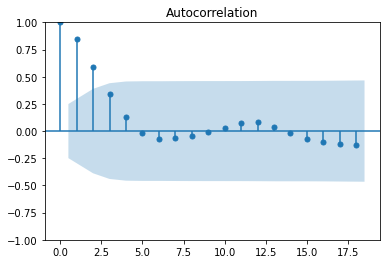

In [12]:
#Fitting an  AR model on the residuals
#sm.graphics.tsaplots.plot_acf(df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'])
sm.graphics.tsa.plot_acf(df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'])
print("More than one significant peak so not white noise model")
print("ACF reduces to insignificant level, but then exhibits periodicity so AR")


PACF(0) is 1, PACF(2) is final significant value so p=2


C:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


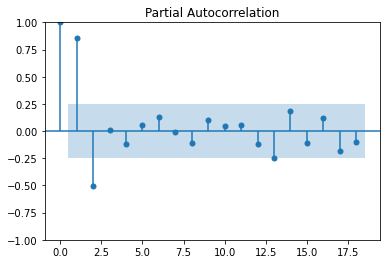

In [13]:
sm.graphics.tsa.plot_pacf(df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'])
print(f"PACF(0) is 1, PACF(2) is final significant value so p=2")

In [14]:
#Now do AR model find the parameters
ar_model = sm.tsa.AutoReg(df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'],lags=[1,2]).fit()
print(f"AIC: {ar_model.aic} BIC:{ar_model.bic}")
print(ar_model.params)
ar_train_predict = ar_model.fittedvalues # this is a Series object
print(ar_model.summary())
#Plot fitted values to the residuals


AIC: 42.93918116849555 BIC:51.31655941738396
const                 0.043105
trend_residuals.L1    1.323666
trend_residuals.L2   -0.530797
dtype: float64
                            AutoReg Model Results                             
Dep. Variable:        trend_residuals   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 -17.470
Method:               Conditional MLE   S.D. of innovations              0.324
Date:                Mon, 14 Mar 2022   AIC                             42.939
Time:                        20:39:39   BIC                             51.317
Sample:                             2   HQIC                            46.216
                                   62                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0431      0.042 

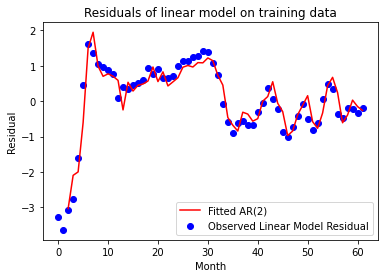

In [15]:
plt.title("Residuals of linear model on training data")
plt.xlabel("Month")
plt.ylabel("Residual")
#plt.plot(np.arange(len(cpi_train)),cpi_train,'r-',label='Actual')
plt.scatter(np.arange(len(cpi_train)),df_cpi[df_cpi['date'] < '2013-09-01']['trend_residuals'],c='b',label='Observed Linear Model Residual')
plt.plot(np.arange(2,2+len(ar_train_predict)),ar_train_predict,c='r',label="Fitted AR(2)")
plt.legend()
plt.show()

In [16]:
df_cpi.tail()

,date,CPI,linear_trend,trend_residuals
131,2019-06-01,117.0359,117.826023,0.790123
132,2019-07-01,117.0592,117.987066,0.927866
133,2019-08-01,117.2548,118.148110,0.893310
134,2019-09-01,117.2488,118.309153,1.060353
135,2019-10-01,117.3407,118.470197,1.129497


In [17]:
#Fit the AR function to the residuals
#first 2 will be zero
t_r = df_cpi.trend_residuals.to_numpy()
AR_fit = [0,0] #first 2 cannot be fit as AR(2)

#TODO: There is probably a better way to do this in numpy....
for time in range(2,len(t_r)):
    fit = 0
    for lag in range(1,3):
        fit += ar_model.params[lag]*t_r[time-lag]
    AR_fit.append(fit+ar_model.params[0])

df_cpi['AR2_model'] = AR_fit
df_cpi['Linear+AR2'] = df_cpi['linear_trend'] -df_cpi['AR2_model']
df_cpi.head()

,date,CPI,linear_trend,trend_residuals,AR2_model,Linear+AR2
0,2008-07-01,100.00000,96.729326,-3.270674,0.000000,96.729326
1,2008-08-01,100.52510,96.890370,-3.634730,0.000000,96.890370
2,2008-09-01,100.12380,97.051413,-3.072387,-3.031997,100.083410
3,2008-10-01,99.98538,97.212457,-2.772923,-2.094402,99.306859
4,2008-11-01,98.97539,97.373500,-1.601890,-1.996503,99.370003


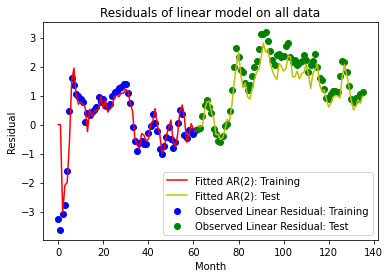

In [18]:

plt.title("Residuals of linear model on all data")
plt.xlabel("Month")
plt.ylabel("Residual")
#plt.plot(np.arange(len(cpi_train)),cpi_train,'r-',label='Actual')
train_length = len(df_cpi[df_cpi['date'] < '2013-09-01'])
plt.scatter(np.arange(train_length),df_cpi['trend_residuals'][0:train_length],c='b',label='Observed Linear Residual: Training')
plt.plot(np.arange(train_length),AR_fit[0:train_length],c='r',label="Fitted AR(2): Training")
plt.scatter(np.arange(train_length,len(df_cpi)),df_cpi['trend_residuals'][train_length:],c='g',label='Observed Linear Residual: Test')
plt.plot(np.arange(train_length,len(df_cpi)),AR_fit[train_length:],c='y',label="Fitted AR(2): Test")
plt.legend()
plt.show()



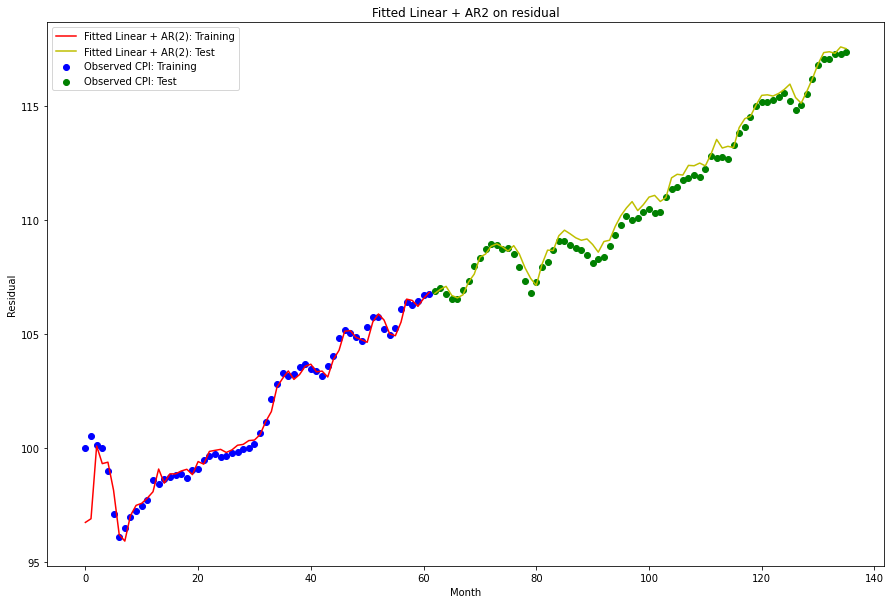

In [19]:
fig = plt.figure(figsize=(15,10))
plt.title("Fitted Linear + AR2 on residual")
plt.xlabel("Month")
plt.ylabel("Residual")
#plt.plot(np.arange(len(cpi_train)),cpi_train,'r-',label='Actual')
train_length = len(df_cpi[df_cpi['date'] < '2013-09-01'])
plt.scatter(np.arange(train_length),df_cpi['CPI'][0:train_length],c='b',label='Observed CPI: Training')
plt.plot(np.arange(train_length),df_cpi['Linear+AR2'][0:train_length],c='r',label="Fitted Linear + AR(2): Training")
plt.scatter(np.arange(train_length,len(df_cpi)),df_cpi['CPI'][train_length:],c='g',label='Observed CPI: Test')
plt.plot(np.arange(train_length,len(df_cpi)),df_cpi['Linear+AR2'][train_length:],c='y',label="Fitted Linear + AR(2): Test")
plt.legend()
plt.show()


In [20]:
#import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print(f"RMSE: {mean_squared_error(df_cpi['Linear+AR2'][train_length:],df_cpi['CPI'][train_length:],squared=False)} MAPE:{mean_absolute_percentage_error(df_cpi['Linear+AR2'][train_length:],df_cpi['CPI'][train_length:])*100}")


RMSE: 0.3910404306996479 MAPE:0.2871575634577724
